In [1]:
import os
import glob
import shutil

import matplotlib.pyplot as plt
import numpy as np
import cv2

from IPython.core.pylabtools import figsize

import torch
import torchvision
from torchvision import datasets, transforms

from torchvision import datasets, models, transforms
import torch.nn as nn

In [2]:
data_dir = "data"

#create training dir
training_dir = os.path.join(data_dir,"training")
if not os.path.isdir(training_dir):
    os.mkdir(training_dir)

#create anderson in training
anderson_training_dir = os.path.join(training_dir,"anderson")
if not os.path.isdir(anderson_training_dir):
    os.mkdir(anderson_training_dir)

#create other in training
other_training_dir = os.path.join(training_dir,"other")
if not os.path.isdir(other_training_dir):
    os.mkdir(other_training_dir)

#create validation dir
validation_dir = os.path.join(data_dir,"validation")
if not os.path.isdir(validation_dir):
    os.mkdir(validation_dir)

#create anderson in validation
anderson_validation_dir = os.path.join(validation_dir,"anderson")
if not os.path.isdir(anderson_validation_dir):
    os.mkdir(anderson_validation_dir)

#create other in validation
other_validation_dir = os.path.join(validation_dir,"other")
if not os.path.isdir(other_validation_dir):
    os.mkdir(other_validation_dir)

In [4]:
anderson_imgs_size = 140
other_imgs_size = 140

for i,img in enumerate(glob.glob("ex1/*")):
    if i < 100:
        shutil.move(img,anderson_training_dir)
    elif i < anderson_imgs_size:
        shutil.move(img,anderson_validation_dir)
    elif i < (240):
        shutil.move(img,other_training_dir)
    else:
        shutil.move(img,other_validation_dir)

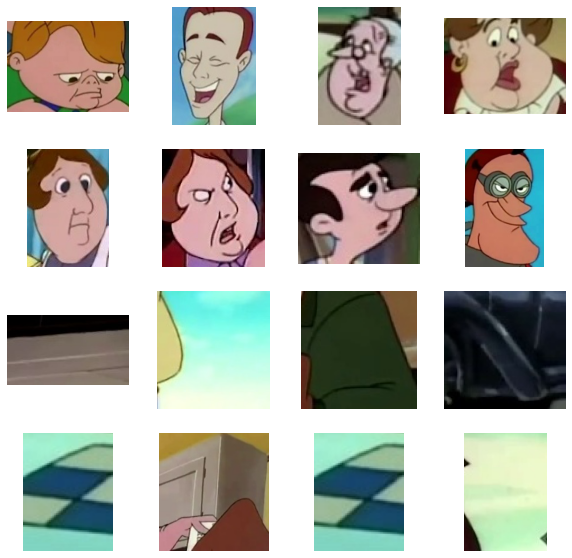

In [5]:
samples_anderson = [os.path.join(anderson_training_dir,np.random.choice(os.listdir(anderson_training_dir),1)[0]) for _ in range(8)]
samples_other = [os.path.join(other_training_dir,np.random.choice(os.listdir(other_training_dir),1)[0]) for _ in range(8)]

nrows = 4
ncols = 4

fig, ax = plt.subplots(nrows,ncols,figsize = (10,10))
ax = ax.flatten()

for i in range(nrows*ncols):
    if i < 8:
        pic = plt.imread(samples_anderson[i%8])
        ax[i].imshow(pic)
        ax[i].set_axis_off()
    else:
        pic = plt.imread(samples_other[i%8])
        ax[i].imshow(pic)
        ax[i].set_axis_off()
plt.show()

In [6]:
traindir = "data/training"
testdir = "data/validation"

#transformations
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),                                
                                       torchvision.transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],
    ),
                                       ])
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      torchvision.transforms.Normalize(
                                          mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225],
    ),
                                      ])

#datasets
train_data = datasets.ImageFolder(traindir,transform=train_transforms)
test_data = datasets.ImageFolder(testdir,transform=test_transforms)

#dataloader
trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=16)

In [7]:
def make_train_step(model, optimizer, loss_fn):
    def train_step(x,y):
        #make prediction
        yhat = model(x)
        #enter train mode
        model.train()
        #compute loss
        loss = loss_fn(yhat,y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        #optimizer.cleargrads()

        return loss
    return train_step

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet18(pretrained=True)

#freeze all params
for params in model.parameters():
    params.requires_grad_ = False

#add a new final layer
nr_filters = model.fc.in_features  #number of input features of last layer
model.fc = nn.Linear(nr_filters, 1)

model = model.to(device)

D:\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler

#loss
loss_fn = BCEWithLogitsLoss() #binary cross entropy with sigmoid, so no need to use sigmoid in the model

#optimizer
optimizer = torch.optim.Adam(model.fc.parameters()) 

#train step
train_step = make_train_step(model, optimizer, loss_fn)

In [10]:
%%capture
!pip install tqdm
from tqdm import tqdm


losses = []
val_losses = []

epoch_train_losses = []
epoch_test_losses = []

n_epochs = 10
early_stopping_tolerance = 3
early_stopping_threshold = 0.03

for epoch in range(n_epochs):
    epoch_loss = 0
    for i ,data in tqdm(enumerate(trainloader), total = len(trainloader)): #iterate ove batches
        x_batch , y_batch = data
        x_batch = x_batch.to(device) #move to gpu
        y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
        y_batch = y_batch.to(device) #move to gpu


        loss = train_step(x_batch, y_batch)
        epoch_loss += loss/len(trainloader)
        losses.append(loss)

    epoch_train_losses.append(epoch_loss)
    print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))

    #validation doesnt requires gradient
    with torch.no_grad():
        cum_loss = 0
        for x_batch, y_batch in testloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
            y_batch = y_batch.to(device)

            #model to eval mode
            model.eval()

            yhat = model(x_batch)
            val_loss = loss_fn(yhat,y_batch)
            cum_loss += loss/len(testloader)
            val_losses.append(val_loss.item())


        epoch_test_losses.append(cum_loss)
        print('Epoch : {}, val loss : {}'.format(epoch+1,cum_loss))  

        best_loss = min(epoch_test_losses)

        #save best model
        if cum_loss <= best_loss:
            best_model_wts = model.state_dict()

        #early stopping
        early_stopping_counter = 0
        if cum_loss > best_loss:
            early_stopping_counter +=1

        if (early_stopping_counter == early_stopping_tolerance) or (best_loss <= early_stopping_threshold):
            print("/nTerminating: early stopping")
            break #terminate training
    
#load best model
model.load_state_dict(best_model_wts)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([69])
Prediction : other


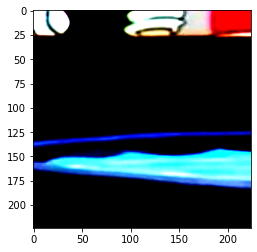

In [11]:
def inference(test_data):
    idx = torch.randint(1, len(test_data), (1,))
    sample = torch.unsqueeze(test_data[idx][0], dim=0).to(device)

    print(idx)
    if torch.sigmoid(model(sample)) < 0.4:
        print("Prediction : face")
    else:
        print("Prediction : other")


    plt.imshow(test_data[idx][0].permute(1, 2, 0))

inference(test_data)

In [29]:
ids = torch.arange(0,80)
print(ids)
predictions =[]
for x in ids:
    sample = torch.unsqueeze(test_data[x][0], dim=0).to(device)
    print("pic ", x, ": ")
    if torch.sigmoid(model(sample)) < 0.49:
        print("Prediction : face")
        predictions.append(1)
    else:
        print("Prediction : other")
        predictions.append(0)
print(predictions)

labels = []
for i in range(80):
    if i<40:
        labels.append(1)
    else:
        labels.append(0)

score = 0
for i in range(80):
    if labels[i]==predictions[i]:
        score+=1
        
print("Accuracy: ", score/80)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79])
pic  tensor(0) : 
Prediction : face
pic  tensor(1) : 
Prediction : face
pic  tensor(2) : 
Prediction : face
pic  tensor(3) : 
Prediction : face
pic  tensor(4) : 
Prediction : face
pic  tensor(5) : 
Prediction : face
pic  tensor(6) : 
Prediction : face
pic  tensor(7) : 
Prediction : face
pic  tensor(8) : 
Prediction : face
pic  tensor(9) : 
Prediction : face
pic  tensor(10) : 
Prediction : face
pic  tensor(11) : 
Prediction : face
pic  tensor(12) : 
Prediction : face
pic  tensor(13) : 
Prediction : face
pic  tensor(14) : 
Prediction : face
pic  tensor(15) : 
Prediction : face
pic  tensor(16) : 
Prediction : face
pic  tensor(17) : 
P